# <div align="center">  Predicting College Football Players Careers Length <br>From Their Performance in College<br>(before the day of the draft) </div>

In [52]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_validate

Getting all the picks of the NFL draft since 1970 till 2021

In [24]:
# https://www.kaggle.com/cviaxmiwnptr/nfl-draft-19702021
df = pd.read_csv('nfl_draft_1970-2021.csv')
df['career_length'] = df['to'] - df['year'] + 1
df = df[['year', 'to','player', 'age', 'career_length']]

Let's try to do a random forest regressor to predict the career length

Now we'll pull the stats of all college players between 2005 and 2013

In [25]:
# https://www.kaggle.com/mhixon/college-football-statistics
folder = '/college_stats/'
sum = 0
data = pd.DataFrame()
for file in glob.glob("*/*/player-game-statistics.csv"):
    stats = pd.read_csv(file)
    sum += len(stats)
    data = pd.concat([data, stats], axis=0)

In [26]:
assert len(data) == sum

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503806 entries, 0 to 57326
Data columns (total 58 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Player Code            503806 non-null  int64  
 1   Game Code              503806 non-null  int64  
 2   Rush Att               503806 non-null  int64  
 3   Rush Yard              503806 non-null  int64  
 4   Rush TD                503806 non-null  int64  
 5   Pass Att               503806 non-null  int64  
 6   Pass Comp              503806 non-null  int64  
 7   Pass Yard              503806 non-null  int64  
 8   Pass TD                503806 non-null  int64  
 9   Pass Int               503806 non-null  int64  
 10  Pass Conv              503806 non-null  int64  
 11  Rec                    503806 non-null  int64  
 12  Rec Yards              503806 non-null  int64  
 13  Rec TD                 503806 non-null  int64  
 14  Kickoff Ret            503806 non-nul

No nulls all numeric

for col in data.columns:
    print(col)
    data[data[col]>0][col].hist()
    plt.show()

In [29]:
gb = data.groupby('Player Code').agg(games=('Game Code', 'count'),
                                               rush_att=('Rush Att', 'sum'),
                                               rush_yard=('Rush Yard','sum'),
                                               rush_td=('Rush TD','sum'),
                                               pass_att=('Pass Att','sum'),
                                               pass_comp=('Pass Comp','sum'),
                                               pass_yard=('Pass Yard','sum'),
                                               pass_td=('Pass TD','sum'),
                                               pass_int=('Pass Int','sum'),
                                               pass_conv=('Pass Conv','sum'),
                                               rec=('Rec','sum'),
                                               rec_yards=('Rec Yards','sum'),
                                               rec_td=('Rec TD','sum'),
                                               kickoff_ret=('Kickoff Ret','sum'),
                                               kickoff_ret_yard=('Kickoff Ret Yard','sum'),
                                               kickoff_ret_td=('Kickoff Ret TD','sum'),
                                               punt_ret=('Punt Ret','sum'),
                                               punt_ret_yard=('Punt Ret Yard','sum'),
                                               punt_ret_td=('Punt Ret TD','sum'),
                                               fum_ret=('Fum Ret','sum'),
                                               fum_ret_yard=('Fum Ret Yard','sum'),
                                               fum_ret_td=('Fum Ret TD','sum'),
                                               int_ret=('Int Ret','sum'),
                                               int_ret_yard=('Int Ret Yard','sum'),
                                               int_ret_td=('Int Ret TD','sum'),
                                               misc_ret=('Misc Ret','sum'),
                                               misc_ret_yard=('Misc Ret Yard', 'sum'),
                                               misc_ret_td=('Misc Ret TD', 'sum'),
                                               field_goal_att=('Field Goal Att', 'sum'),
                                               field_goal_made=('Field Goal Made', 'sum'),
                                               off_xp_kick_att=('Off XP Kick Att', 'sum'),
                                               off_xp_kick_made=('Off XP Kick Made', 'sum'),
                                               off_2xp_att=('Off 2XP Att', 'sum'),
                                               off_2xp_made=('Off 2XP Made', 'sum'),
                                               def_2xp_att=('Def 2XP Att', 'sum'),
                                               def_2xp_made=('Def 2XP Made', 'sum'),
                                               safety=('Safety', 'sum'),
                                               points=('Points', 'sum'),
                                               punt=('Punt', 'sum'),
                                               punt_yard=('Punt Yard', 'sum'),
                                               kickoff=('Kickoff', 'sum'),
                                               kickoff_yard=('Kickoff Yard', 'sum'),
                                               kickoff_touchback=('Kickoff Touchback', 'sum'),
                                               kickoff_out_of_bounds=('Kickoff Out-Of-Bounds', 'sum'),
                                               kickoff_onside=('Kickoff Onside', 'sum'),
                                               fumble=('Fumble', 'sum'),
                                               fumble_lost=('Fumble Lost', 'sum'),
                                               tackle_solo=('Tackle Solo', 'sum'),
                                               tackle_assist=('Tackle Assist', 'sum'),
                                               tackle_for_loss=('Tackle For Loss', 'sum'),
                                               tackle_for_loss_yard=('Tackle For Loss Yard', 'sum'),
                                               sack=('Sack', 'sum'),
                                               sack_yard=('Sack Yard', 'sum'),
                                               qb_hurry=('QB Hurry', 'sum'),
                                               fumble_forced=('Fumble Forced', 'sum'),
                                               pass_broken_up=('Pass Broken Up', 'sum'),
                                               kick_or_punt_blocked=('Kick/Punt Blocked', 'sum'))

# https://www.kaggle.com/mhixon/college-football-statistics
folder = '/college_stats/'
sum = 0
players = pd.DataFrame()
for file in glob.glob("*/*/player.csv"):
    players_temp = pd.read_csv(file)
    sum += len(players_temp)
    players = pd.concat([players, players_temp], axis=0)
    
players['name'] = players['First Name'] + ' ' + players['Last Name']

gb = gb.merge(players[['Player Code', 'name']], left_index=True, right_on=['Player Code'])
gb = gb.set_index('name')
gb = gb.drop_duplicates()

In [30]:
list(gb.columns)

['games',
 'rush_att',
 'rush_yard',
 'rush_td',
 'pass_att',
 'pass_comp',
 'pass_yard',
 'pass_td',
 'pass_int',
 'pass_conv',
 'rec',
 'rec_yards',
 'rec_td',
 'kickoff_ret',
 'kickoff_ret_yard',
 'kickoff_ret_td',
 'punt_ret',
 'punt_ret_yard',
 'punt_ret_td',
 'fum_ret',
 'fum_ret_yard',
 'fum_ret_td',
 'int_ret',
 'int_ret_yard',
 'int_ret_td',
 'misc_ret',
 'misc_ret_yard',
 'misc_ret_td',
 'field_goal_att',
 'field_goal_made',
 'off_xp_kick_att',
 'off_xp_kick_made',
 'off_2xp_att',
 'off_2xp_made',
 'def_2xp_att',
 'def_2xp_made',
 'safety',
 'points',
 'punt',
 'punt_yard',
 'kickoff',
 'kickoff_yard',
 'kickoff_touchback',
 'kickoff_out_of_bounds',
 'kickoff_onside',
 'fumble',
 'fumble_lost',
 'tackle_solo',
 'tackle_assist',
 'tackle_for_loss',
 'tackle_for_loss_yard',
 'sack',
 'sack_yard',
 'qb_hurry',
 'fumble_forced',
 'pass_broken_up',
 'kick_or_punt_blocked',
 'Player Code']

for col in gb.describe().columns:
    print(col)
    gb[gb[col]>0][col].hist()
    plt.show()

In [31]:
gb = gb.merge(df[['player', 'career_length']],left_index=True, right_on='player', how='inner').set_index('player')
gb = gb.drop_duplicates()

for col in gb.columns:
    print(col)
    gb[gb[col]>0][col].hist()
    plt.show()

In [32]:
gb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5244 entries, Mark Merrill to Denzel Ward
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   games                  5244 non-null   int64  
 1   rush_att               5244 non-null   int64  
 2   rush_yard              5244 non-null   int64  
 3   rush_td                5244 non-null   int64  
 4   pass_att               5244 non-null   int64  
 5   pass_comp              5244 non-null   int64  
 6   pass_yard              5244 non-null   int64  
 7   pass_td                5244 non-null   int64  
 8   pass_int               5244 non-null   int64  
 9   pass_conv              5244 non-null   int64  
 10  rec                    5244 non-null   int64  
 11  rec_yards              5244 non-null   int64  
 12  rec_td                 5244 non-null   int64  
 13  kickoff_ret            5244 non-null   int64  
 14  kickoff_ret_yard       5244 non-null   int6

In [33]:
gb[gb['career_length'].isna()]

,games,rush_att,rush_yard,rush_td,pass_att,pass_comp,pass_yard,pass_td,pass_int,pass_conv,...,tackle_for_loss,tackle_for_loss_yard,sack,sack_yard,qb_hurry,fumble_forced,pass_broken_up,kick_or_punt_blocked,Player Code,career_length
player,,,,,,,,,,,,,,,,,,,,,
Tyler Reed,1,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0,0,60,NaN
Tyler Reed,12,13,60,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0,0,1008574,NaN
George Bussey,7,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0,0,86,NaN
Chris Miller,12,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0,0,30988,NaN
Chris Miller,11,0,0,0,0,0,0,0,0,0,...,2.5,9,2.0,8,0,1,0,0,37017,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Aaron Jackson,4,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0,0,1058395,NaN
Keion Adams,10,0,0,0,0,0,0,0,0,0,...,2.5,12,1.0,8,1,1,1,0,1058400,NaN
Jay Anderson,1,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0,0,0,0,0,1060062,NaN


# Bar Please fix the duplicates!!!!

In [34]:
gb = gb.dropna()

In [35]:
list(gb.columns)

['games',
 'rush_att',
 'rush_yard',
 'rush_td',
 'pass_att',
 'pass_comp',
 'pass_yard',
 'pass_td',
 'pass_int',
 'pass_conv',
 'rec',
 'rec_yards',
 'rec_td',
 'kickoff_ret',
 'kickoff_ret_yard',
 'kickoff_ret_td',
 'punt_ret',
 'punt_ret_yard',
 'punt_ret_td',
 'fum_ret',
 'fum_ret_yard',
 'fum_ret_td',
 'int_ret',
 'int_ret_yard',
 'int_ret_td',
 'misc_ret',
 'misc_ret_yard',
 'misc_ret_td',
 'field_goal_att',
 'field_goal_made',
 'off_xp_kick_att',
 'off_xp_kick_made',
 'off_2xp_att',
 'off_2xp_made',
 'def_2xp_att',
 'def_2xp_made',
 'safety',
 'points',
 'punt',
 'punt_yard',
 'kickoff',
 'kickoff_yard',
 'kickoff_touchback',
 'kickoff_out_of_bounds',
 'kickoff_onside',
 'fumble',
 'fumble_lost',
 'tackle_solo',
 'tackle_assist',
 'tackle_for_loss',
 'tackle_for_loss_yard',
 'sack',
 'sack_yard',
 'qb_hurry',
 'fumble_forced',
 'pass_broken_up',
 'kick_or_punt_blocked',
 'Player Code',
 'career_length']

In [46]:
target = 'career_length'
X = gb[gb.columns.drop(target)]
y = gb[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3180, 58), (1364, 58), (3180,), (1364,))

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestRegressor(criterion='mse')
scores = cross_validate(rf, X_train, y_train, cv=kf, scoring='r2')

In [56]:
scores

{'fit_time': array([1.47034669, 1.42353106, 1.41672397, 1.43870115, 1.38976216]),
 'score_time': array([0.01131105, 0.01145482, 0.01147795, 0.01163578, 0.01135993]),
 'test_score': array([-0.16843052, -0.11457459, -0.09757556, -0.10417954, -0.19830319])}

In [57]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [58]:
rf.score(X_train, y_train)

0.7751098039878835

In [59]:
rf.score(X_test, y_test)

-0.13016006203767394

<AxesSubplot:>

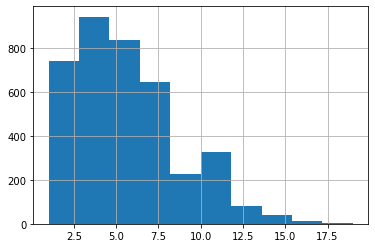

In [44]:
y_train.hist()

<AxesSubplot:>

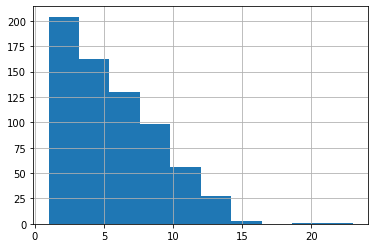

In [45]:
y_test.hist()